In [1]:
import pandas as pd
import seaborn as sns

In [2]:
df = pd.read_csv('../data/titanic/train.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
df.sample(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
596,597,1,2,"Leitch, Miss. Jessie Wills",female,NaN,0,0,248727,33.0,NaN,S
874,875,1,2,"Abelson, Mrs. Samuel (Hannah Wizosky)",female,28.0,1,0,P/PP 3381,24.0,NaN,C


In [16]:
def clean(df):
    df['Cabin'] = df.Cabin.str.slice(0, 1)
    df = pd.get_dummies(df, dummy_na=True, columns=['Cabin', 'Embarked', 'Pclass'])
    
    df['AgeNull'] = df.Age.isna()
    df.Age.fillna(0, inplace=True)
    
    df.drop(columns='PassengerId Name Ticket'.split(), inplace=True)
    df['Sex'] = df.Sex == 'male'
    
    return df

In [17]:
cleaned = clean(df.copy())

In [18]:
from sklearn.model_selection import train_test_split

# we make our test set
X_train, X_test, y_train, y_test = train_test_split(cleaned.drop(columns='Survived'), cleaned.Survived, test_size=0.2)

# and we make our validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [19]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

In [24]:
# looks like cols 1, 2, 
cleaned.drop(columns='Survived').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 23 columns):
Sex             891 non-null bool
Age             891 non-null float64
SibSp           891 non-null int64
Parch           891 non-null int64
Fare            891 non-null float64
Cabin_A         891 non-null uint8
Cabin_B         891 non-null uint8
Cabin_C         891 non-null uint8
Cabin_D         891 non-null uint8
Cabin_E         891 non-null uint8
Cabin_F         891 non-null uint8
Cabin_G         891 non-null uint8
Cabin_T         891 non-null uint8
Cabin_nan       891 non-null uint8
Embarked_C      891 non-null uint8
Embarked_Q      891 non-null uint8
Embarked_S      891 non-null uint8
Embarked_nan    891 non-null uint8
Pclass_1.0      891 non-null uint8
Pclass_2.0      891 non-null uint8
Pclass_3.0      891 non-null uint8
Pclass_nan      891 non-null uint8
AgeNull         891 non-null bool
dtypes: bool(2), float64(2), int64(2), uint8(17)
memory usage: 44.5 KB


In [27]:
def feature_preprocess(X, y, skb=None, ss=None):
    if ss is None:
        ss = StandardScaler()
        ss.fit(X)
        
    X = ss.transform(X)
    
    if skb is None:
        skb = SelectKBest(mutual_info_classif, k=10)
        skb.fit(X, y)
        
    X = skb.transform(X)
        
    return X, y, skb, ss

In [30]:
X_proc, y_proc, skb, ss = feature_preprocess(X_train, y_train)

In [29]:
from sklearn.linear_model import LogisticRegression

In [31]:
lr = LogisticRegression()

lr.fit(X_proc, y_proc)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [32]:
lr.score(X_proc, y_proc)

0.8084358523725835

In [47]:
X_proc, y_proc, skb, ss = feature_preprocess(X_val, y_val, skb, ss)

In [48]:
lr.score(X_proc, y_proc)

0.7272727272727273

In [49]:
from sklearn.metrics import confusion_matrix

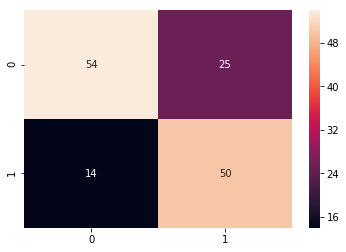

In [50]:
sns.heatmap(confusion_matrix(y_proc, lr.predict(X_proc)), annot=True)

In [51]:
from sklearn.metrics import classification_report

In [52]:
print(classification_report(y_proc, lr.predict(X_proc)))

             precision    recall  f1-score   support

          0       0.79      0.68      0.73        79
          1       0.67      0.78      0.72        64

avg / total       0.74      0.73      0.73       143



In [53]:
y_test = y_proc
y_score = lr.decision_function(X_proc)

In [54]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.81')

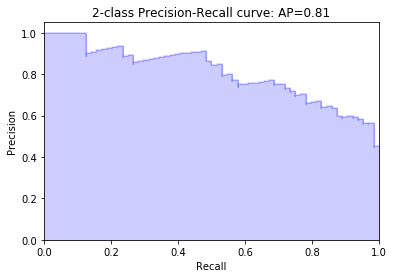

In [55]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

precision, recall, _ = precision_recall_curve(y_test, y_score)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [57]:
from sklearn.neighbors import KNeighborsClassifier

In [58]:
knn = KNeighborsClassifier(5)

In [59]:
knn.fit(train_features, train.Survived)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [60]:
knn.score(train_features, train.Survived)

0.8426966292134831

In [63]:
test['Sex'] = test.Sex == 'male'
test_X = skb.transform(test.drop(columns=['Survived']))

/Users/tucker/Desktop/data-science-foundations-master/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [64]:
quant_features = ss.transform(test_X[:, [1, 2, 3]])

In [65]:
qual_features = test_X[:, [0, 4, 5, 6, 7, 8, 9]]

In [66]:
test_features = np.concatenate([quant_features, qual_features], axis=1)

In [67]:
test_features.shape

(268, 10)

In [68]:
knn.score(test_features, test.Survived)

0.835820895522388

In [71]:
import seaborn as sns

/Users/tucker/Desktop/data-science-foundations-master/env/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


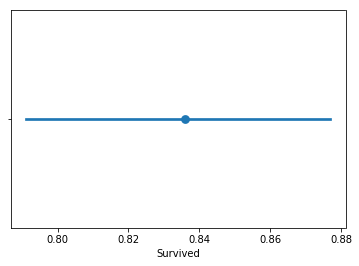

In [72]:
sns.pointplot(knn.predict(test_features) == test.Survived)